## 1. Introduction

Welcome to a tutorial to get you quickly up to speed with *deep learning*; from first principles, all the way to discussions of some of the intricate details. By the end of this part of the tutorial, you should be capable of understanding and producing a simple CNN (with a structure similar to LeNet architecture) in Keras, achieving a respectable level of accuracy on the first step of this challenge. 


## 2. Convolutions

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)




## 3. Convolutional layers and Pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a CNN. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks ([Keras included](https://keras.io/layers/convolutional/)) will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/pool.png)


## 4. Convolutional Neural Network (CNN) architecture

Now that we got all the building blocks, let's see what a typical convolutional neural network might look like!

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/cnn.png)

A typical CNN architecture for a $k$-class image classification can be split into two distinct parts---a chain of repeating $\mathrm{Conv}\rightarrow\mathrm{Pool}$ layers (sometimes with more than one convolutional layer at once), followed by a few fully connected layers (taking each pixel of the computed images as an independent input), culminating in a $k$-way softmax layer, to which a cross-entropy loss is optimised. I did not draw the activation functions here to make the sketch clearer, but do keep in mind that typically after every convolutional or fully connected layer, an activation (e.g. ReLU) will be applied to all of the outputs.

Note the effect of a single $\mathrm{Conv}\rightarrow\mathrm{Pool}$ pass through the image: it reduces height and width of the individual channels in favour of their number, i.e. *depth*.

For summarisation purposes, a softmax layer's purpose is converting any vector of real numbers into a vector of *probabilities* (nonnegative real values that add up to 1). Within this context, the probabilities correspond to the likelihoods that an input image is a member of a particular class. Minimising the cross-entropy loss has the effect of maximising the model's confidence in the *correct* class, without being concerned for the probabilites for other classes---this makes it a more suitable choice for probabilistic tasks compared to, for example, the squared error loss.


## 5. Detour: Overfitting, regularisation and dropout

It regards a very important pitfall of machine learning---**overfitting** a model to the training data and we need to introduce a way to properly protect ourselves against it, before going any further. Luckily, there is a very simple technique we can use.

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a sine curve, with white additive noise applied to the data points: 

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/plotsin.png)

Here we have a training set (denoted by blue circles) derived from the original sine wave, along with some noise. If we fit a degree-3 polynomial to this data, we get a fairly good approximation to the original curve. Someone might argue that a degree-14 polynomial would do better; indeed, given we have 15 points, such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters, we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method introduced here is **dropout**---a technique that initially might seem like "dark magic", but actually helps to eliminate exactly the failure modes described above. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers. An illustration is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/drop.png)

## 6. Applying a deep CNN to Challenge Data Set

As this post's objective, we will implement a deep convolutional neural network---and apply it on our satellites images data set in order to classify those : parking/not parking.


As already mentioned, a CNN will typically have more hyperparameters than an MLP. For the purposes of this tutorial, we will also stick to "sensible" hand-picked values for them.

The hyperparameters are:
- The *batch size*, representing the number of training examples being used simultaneously during a single iteration of the gradient descent algorithm;
- The number of *epochs*, representing the number of times the training algorithm will iterate over the entire training set before terminating\*;
- The *kernel sizes* in the convolutional layers;
- The *pooling size* in the pooling layers;
- The *number of kernels* in the convolutional layers;
- The *dropout probability* (we will apply dropout after each pooling, and after the fully connected layer);
- The *number of neurons* in the fully connected layer of the MLP.

\* **N.B. here I have set the number of epochs to 100, which might be undesirably slow if you do not have a GPU at your disposal (the convolution layers are going to pose a significant performance bottleneck in this case). You might wish to decrease the epoch count and/or numbers of kernels if you are going to be training the network on a CPU.**



Modelling time! Our network has an architecture similar to LeNet5 of LeCun (see figure below). It will consist of two consecutive groups of one `Convolution2D` followed by  a `MaxPooling2D` layer. After the first pooling layer, the number of kernels is rougly doubled (in line with the previously mentioned principle of sacrificing height and width for more depth). Afterwards, the output of the second pooling layer is flattened to 1D (via the `Flatten` layer), and passed through one or two fully connected (`Dense`) layers. ReLU activations will once again be used for all layers except the output dense layer, which will use a softmax activation (for purposes of probabilistic classification).

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lenet5.png)

To regularise our model, a `Dropout` layer is applied after each pooling layer, and after the first `Dense` layer. This is another area where Keras shines compared to other frameworks: it has an internal flag that automatically enables or disables dropout, depending on whether the model is currently used for training or testing.

The remainder of the model specification is the following:
- We use the *cross-entropy* loss function as the objective to optimise (as its derivation is more appropriate for probabilistic tasks);
- We use the [*Adam* optimiser for gradient descent](http://sebastianruder.com/optimizing-gradient-descent/);
- We report the *accuracy* of the model (as the dataset is balanced across the ten classes)\*;
- We hold out 10% of the data for validation purposes.

\* To get a feeling for why accuracy might be inappropriate for unbalanced datasets, consider an extreme case where 90% of the test data belongs to class $x$ (this could be, for example, the task of diagnosing patients for an extremely rare disease). In this case, a classifier that just outputs $x$ achieves a seemingly impressive accuracy of 90% on the test data, without really doing any learning/generalisation.

# 8. Just show me the code!


This code assume your already have installed <code>numpy</code>, <code>keras</code>, <code>tensorflow</code>, ... on your computer. If not, uncomment the adequate lines in the cell below:

In [1]:
import sys
print('Your python version: {}'.format(sys.version_info.major))
# Uncomment lines below only if you need them 
#!{sys.executable} -m pip install -U numpy --user
#!{sys.executable} -m pip install -U matplotlib --user
#!{sys.executable} -m pipinstall -U keras --user
#!{sys.executable} -m pip install -U tensorflow --user
#!{sys.executable} -m pip install -U theano --user

Your python version: 3


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'
if FORCE_CPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

NameError: name 'USE_TENSORFLOW_AS_BACKEND' is not defined

In [8]:
import csv
import keras
from keras import backend as K
from keras import regularizers
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Input, Conv3D, MaxPooling3D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.preprocessing import image
print('Your keras version: {}'.format(keras.__version__))
import tensorflow
print('Your tensorflow version: {}'.format(tensorflow.__version__))


Using TensorFlow backend.


Your keras version: 2.2.4
Your tensorflow version: 1.13.1


In [12]:
# --------------------------------------
# Dataset variables

height, width, depth = 256, 256, 3 # Our Images are 256*256 pixels, and coloured so 3 channels ( bleu/green/red)
num_classes = 2 
set_test_size=2000
pathtrain=[]
Y_train=[]
pathholdout=[]
# there are 2 classes parking/notparking
# --------------------------------------
# Dataset loading & preprocessing
# --------------------------------------
with open('train.csv', newline='') as csvfile:      # Paste here name and path of the training datacsv on your computer
    datareader = csv.reader(csvfile, delimiter=';', quotechar='|')
    for row in datareader:
        Y_train.append(row[1]
        pathtrain.append(row[0])               
# --------------------------------------
with open('hold_out.csv', newline='') as csvfile:   # Paste here name and path of the scoring csv on your computer
    Scoringdatareader = csv.reader(csvfile, delimiter=';', quotechar='|')
    for row in datareader:
        pathholdout.append(row[0]) 
                           
X_hold_out=np.ones((len(pathholdout), 256, 256, 3))
X_train=np.ones((len(pathtrain), 256, 256, 3))
for i in range(len(pathholdout)):
    img = image.load_img("F:\Hackathon\All\{}".format(pathholdout[i]))  # Replace by local path of images folder
    X_hold_out[i]=image.img_to_array(img)[:256,:256,:]
    img.close()

for i in range(len(pathtrain)):
    img2 =image.load_img("F:\Hackathon\All\{}".format(pathtrain[i])) # Replace by local path of images folder
    X_train[i]=image.img_to_array(img2)[:256,:256,:]
    img2.close()
    
X_test=X_train[0:set_test_size,:,:,:]
Y_test=Y_train[0:set_test_size,:,:,:]

X_train/= 255. # Normalise data to [0, 1] range
X_test /= 255. # Normalise data to [0, 1] range
X_hold_out /= 255. # Normalise data to [0, 1] range
#X_train = X_train[:,newaxis,:,:,:] # Reshape in "convolutionable" format (add tensor dim for the depth)
#X_test = X_test[:,newaxis,:,:,:] # Reshape in "convolutionable" format (add tensor dim for the depth)

X_train=X_train.reshape(X_train.shape[0],
                1,
                X_train.shape[1],
                X_train.shape[2],
                X_train.shape[3])
                           
Y_train = np_utils.to_categorical(Y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(Y_test, num_classes) # One-hot encode the labels

print(Y_train.shape)

SyntaxError: invalid syntax (<ipython-input-12-5e4d9fc6ba5c>, line 15)

In [11]:
# --------------------------------------
# Network params
# --------------------------------------
# Network params
batch_size = 30    # in each iteration, we consider 32 training examples at once
num_epochs = 10    # we iterate 20 times over the entire training set
kernel_size = 5    # we will use 5x5 kernels throughout
pool_size = 2      # we will use 2x2 pooling throughout
conv_depth_1 = 6   # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.1  # dropout after pooling with probability 0.1
drop_prob_2 = 0.1   # dropout in the FC layer with probability 0.1
hidden_size = 128  # the FC layer will have 128neurons
weight_penalty = 0.1 # Factor for weights penalty

# --------------------------------------
# CNN network definition
# --------------------------------------
# model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model = Sequential() #(256,256,3,1)
# Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv3D(conv_depth_1, (kernel_size,kernel_size,kernel_size), 
                  border_mode='same', activation='relu', 
                  data_format="channels_first",
                  input_shape=(1,256, 256, 3)) )#(256,256,3,6)
model.add( MaxPooling3D(pool_size=(1,pool_size, pool_size)) )#(128,128,3,6)
model.add( Dropout(drop_prob_1) ) 

# Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv3D(conv_depth_2, (kernel_size,kernel_size,kernel_size), 
                  border_mode='same',
                  data_format="channels_first",
                  activation='relu') )#(128,128,3,16)
model.add( MaxPooling3D(pool_size=(1,pool_size, pool_size)) )#(64,64,3,16)
model.add( Dropout(drop_prob_1) )

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )#(64*64*3*16)
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )#(128)
model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )#(2)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(6, (5, 5, 5), activation="relu", data_format="channels_first", input_shape=(1, 256, 2..., padding="same")`


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 6, 256, 256, 3)    756       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 128, 128, 3)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 128, 128, 3)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 128, 128, 3)   12016     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 64, 64, 3)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 64, 64, 3)     0         
___________________________

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (5, 5, 5), data_format="channels_first", activation="relu", padding="same")`


In [10]:
# --------------------------------------
# Loss function and Optimizer
# --------------------------------------
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1,validation_split=0.2) # ...holding out 20% of the data for validation  ,validation_split=0.2

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the test set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the trained set ! test set!

C:\Users\Guest\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/2
90/90 [==============================] - 74s 819ms/step - loss: 1.2629 - accuracy: 0.6778
Epoch 2/2
90/90 [==============================] - 73s 810ms/step - loss: 0.4897 - accuracy: 0.8889


ValueError: Error when checking input: expected conv3d_1_input to have 5 dimensions, but got array with shape (10, 256, 256, 3)

KeyError: 'val_loss'

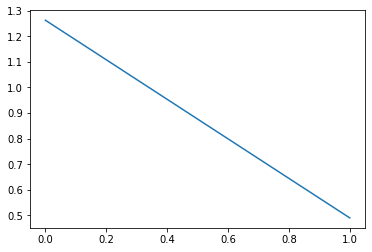

In [11]:
# --------------------------------------
# Loss functions evolution (let's search for overfitting)
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()



now you can correct this code ( check the regularizations techniques above ) and upload to the platforme the following file

In [6]:
#to upload on platform 
Y_hold_out= model.predict(X_score, batch_size=batch_size, verbose=1)

with open('Result.csv', 'wb') as csvfile:
    scoringdatawriter = csv.writer(csvfile, delimiter='; ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(pathholdout)):
        scoringdatawriter.writerow([pathholdout[i], Y_hold_out[i]])
    

NameError: name 'model' is not defined